In [1]:
using ForwardDiff
using Printf
using PyPlot
using PorousMaterials
using Colors
using ColorSchemes
using LaTeXStrings
using DataFrames

PyPlot.matplotlib.style.use("seaborn-pastel")

rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["font.size"] = 16

16

# Data structure for a MORF
* $\delta$ is...
* $\epsilon_\heartsuit$ is...
* $\epsilon_\Delta$ is...


We define _material space_ to be $( \delta, \epsilon_\heartsuit, \epsilon_\triangle)$.

In [2]:
struct Material
    δ::Float64
    ϵ♡::Float64
    ϵΔ::Float64
end

function Base.show(io::IO, material::Material)
    @printf("MORF material with:\n\tδ = %.3f\n\tϵ♡ = %.3f\n\tϵΔ = %.3f\n", material.δ, material.ϵ♡, material.ϵΔ)
end

# Adsorption isotherm of a MORF

\begin{equation}
    \langle n \rangle(P) = \dfrac{K \beta P}{1+K \beta P}
\end{equation} where:
\begin{equation}
K=K(\beta; \delta, \epsilon_\heartsuit, \epsilon_\triangle)=\dfrac{1}{1+e^{-\beta\delta}}e^{-\beta \epsilon_\triangle} + \dfrac{e^{-\beta\delta}}{1+e^{-\beta\delta}}e^{-\beta \epsilon_\heartsuit}
\end{equation}.

In [3]:
function K(material::Material, β::Real) # must assert β::Real as opposed to β::Float64 for ForwardDiff.jl to work
    p♡ = 1 / (1 + exp(-β * material.δ)) # probability ring is on ♡ when gas is absent
    return p♡ * exp(-β * material.ϵΔ) + (1 - p♡) * exp(-β * material.ϵ♡)
end

function expected_n(material::Material, β::Real, P::Float64) # must use Real for ForwardDiff.jl
    KβP = K(material, β) * β * P
    return KβP / (1.0 + KβP)
end

expected_n (generic function with 1 method)

plot a generic isotherm for the paper

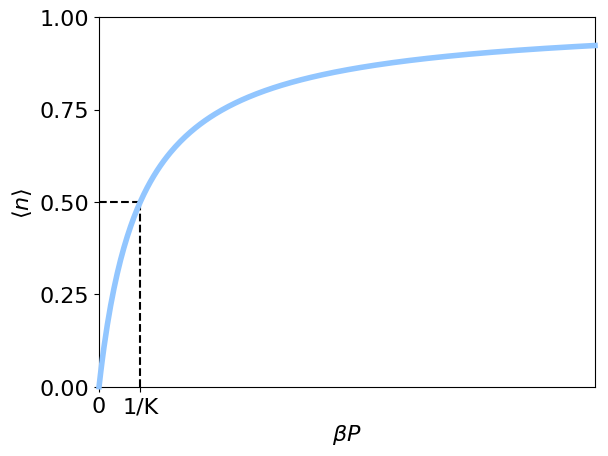

In [4]:
material = Material(1.0, -1.0, -1.5)
βP = range(0.0, stop=3.0, length=300)
n = [expected_n(material, 1.0, βP_i) for βP_i in βP]

figure()
# grid("on", linestyle="--", zorder=2)

βP_half_max = 1 / K(material, 1.0)
plot([βP_half_max, βP_half_max], [0.0, 0.5], color="k", linestyle="--")
plot([0, βP_half_max], [0.5, 0.5], color="k", linestyle="--")

xlabel(L"$\beta P$")
ylabel(L"$\langle n \rangle$")

plot(βP, n, lw=4, clip_on=false, zorder=100)
xlim([0.0, maximum(βP)]) # keep this after line above
ylim([0.0, 1.0])

xticks([0, βP_half_max], [0, "1/K"])
yticks([i * 0.25 for i = 0:4])
savefig("adsorption_isotherm.pdf", format="pdf")

# Searching for anamolous behavior

## Can $\langle n \rangle$ *increase* when temperature increases?
i.e. is there a region of material space and a temperature $\beta$ such that:
\begin{equation}
   \left( \dfrac{\partial \langle n \rangle}{\partial \beta} \right)_P <0?
\end{equation}

let's use auto-differentiation to computationally explore material space and $\beta$ to see if this happens.

We proved that the following quantity has the same sign as $\partial \langle n \rangle / \partial \beta$:
\begin{equation}
   \left( \dfrac{\partial (K\beta)}{\partial \beta} \right)_P .
\end{equation}

In [42]:
function ∂Kβ_∂β(material::Material, β::Float64)
    # view K as a function of β only.
    Kβ(x) = K(material, x[1]) * x[1] # x plays role of β
    ∂Kβ_∂β_of_β = x -> ForwardDiff.gradient(Kβ, x) # x plays role of β
    return ∂Kβ_∂β_of_β([β])[1]
end

# test with centered difference
material = Material(2.0, -3.0, -1.0)
β = 1.0
ϵ = 1e-8
@assert isapprox((K(material, β + ϵ) * (β + ϵ) - K(material, β - ϵ) * (β - ϵ)) / (2 * ϵ), 
    ∂Kβ_∂β(material, β))

In [43]:
function ∂n_∂β(material::Material, β::Float64, P::Float64)
    # view n as a function of β only.
    n(x) = expected_n(material, x[1], P) # x plays role of β
    ∂n_∂β_of_β = x -> ForwardDiff.gradient(n, x) # x plays role of β
    return ∂n_∂β_of_β([β])[1]
end

# test with centered difference
material = Material(2.1, -3.7, -1.9)
β = 0.1
P = 4.4
ϵ = 1e-8
@assert isapprox((expected_n(material, β + ϵ, P) - expected_n(material, β - ϵ, P)) / (2 * ϵ), 
    ∂n_∂β(material, β, P), rtol=0.0001)
@assert isapprox(∂n_∂β(material, β, P), ∂Kβ_∂β(material, β) * P / (1 + K(material, β) * β * P) ^ 2)

assert that $\dfrac{d(K\beta)}{d\beta}$ is a function of $(\beta \delta, \beta \epsilon_\triangle, \beta \epsilon_\heartsuit)$ only, as pencil and paper math suggests.

In [44]:
@assert isapprox(∂Kβ_∂β(Material(2.4, -1.45, -6.7), 1.0), ∂Kβ_∂β(Material(2.4 * 3, -1.45 * 3, -6.7 * 3), 1.0 / 3))

search param space  $(\beta \delta, \beta \epsilon_\triangle, \beta \epsilon_\heartsuit)$ for anamolous behavior. store in a grid and write as a `.cube` file for viz

In [8]:
nb_pts = 25
max_βE = 25.0
βδ_range = range(0.0, stop=max_βE, length=nb_pts)
βϵ♡_range = range(-max_βE, stop=0.0, length=nb_pts)
βϵΔ_range = range(-max_βE, stop=0.0, length=nb_pts)
# b/c it's really only a function of (βδ, βϵ♡, βϵΔ) [see pencil and paper math]
β = 1.0

box = Box(max_βE, max_βE, max_βE, π/2, π/2, π/2)
grid = Grid(box, (nb_pts, nb_pts, nb_pts), zeros(Float64, nb_pts, nb_pts, nb_pts), :wutevs,
    [0.0, -max_βE, -max_βE])

for (i, βδ) in enumerate(βδ_range)
    for (j, βϵ♡) in enumerate(βϵ♡_range)
        for (k, βϵΔ) in enumerate(βϵΔ_range)
            material = Material(βδ, βϵ♡, βϵΔ)
            grid.data[i, j, k] = ∂Kβ_∂β(material, β)
            if ∂Kβ_∂β(material, β) < 0.0
                println("∂⟨n⟩/∂β < 0! ", material)
            end
            @assert (∂Kβ_∂β(material, β) < 0.0) == (∂n_∂β(material, β, rand()) < 0.0)
        end
    end
end

isdir("data") ? nothing : mkdir("data")
write_cube(grid, "∂Kβ_∂β.cube")

	See /home/cokes/MORF_model/data/grids/∂Kβ_∂β.cube


MORF material with:
	δ = 45.833
	ϵ♡ = -47.917
	ϵΔ = -4.167
∂(Kβ)/∂β = -55.52914423035989
∂(Kβ)/∂β = 

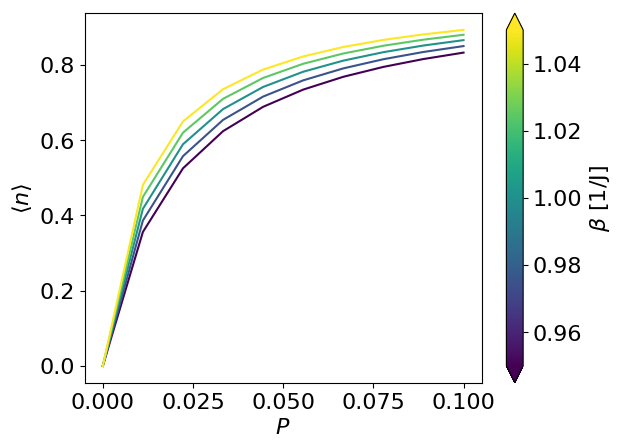

-46.55496267743657
∂(Kβ)/∂β = -34.95614786814974
∂(Kβ)/∂β = -20.293084057552633
∂(Kβ)/∂β = -2.064269177496456


PyObject Text(34.0, 0.5, '$\\langle n \\rangle$')

In [50]:
material = Material(45.833, -47.917, -4.167)
print(material)

P = range(0.0, stop=0.1, length=10)
β = range(0.95, stop=1.05, length=5)

cnorm = PyPlot.matplotlib.colors.Normalize(vmin=minimum(β), vmax=maximum(β))
β_to_color = PyPlot.matplotlib.cm.ScalarMappable(norm=cnorm, cmap=PyPlot.matplotlib.cm.get_cmap("viridis"))
β_to_color.set_array([])

figure()
for β_i in β
    println("∂(Kβ)/∂β = ", ∂Kβ_∂β(material, β_i))
    n = [expected_n(material, β_i, P_i) for P_i in P]
    plot(P, n, color=β_to_color.to_rgba(β_i))
end
colorbar(β_to_color, label=L"$\beta$ [1/J]", extend="both")

xlabel(L"$P$")
ylabel(L"$\langle n \rangle$")

watch: `∂n_∂β` function tells us it is negative yet we increase `β` and see `n` increase!

In [10]:
β = 1.0
P = 0.1
∂n_∂β(material, β, P)

-0.0629447140572818

In [11]:
expected_n(material, β, P)

0.8658107119873939

In [12]:
expected_n(material, β + 0.001, P)

0.8664098353785192

# ring position

\begin{equation}
    \langle r \rangle = 
   \left(\frac{e^{-\beta \delta}}{1+e^{-\beta \delta}} \right)
   \left( \frac{1+e^{-\beta \epsilon_\heartsuit}\beta P}{1+K\beta P}\right),
\end{equation}

In [13]:
function expected_r(material::Material, β::Float64, P::Float64)
    p_Δ = exp(-β * material.δ) / (1 + exp(-β * material.δ)) # in two-state model for ring without gas
    return p_Δ * (1 + exp(-β * material.ϵ♡) * β * P) / (1 + K(material, β) * β * P)
end

expected_r (generic function with 1 method)

### show dependence on gas uptake

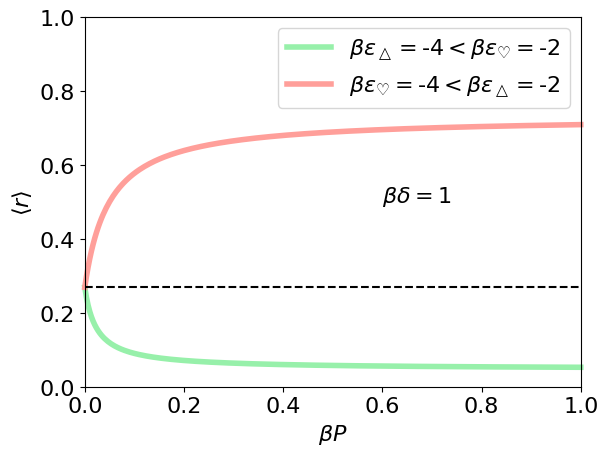

material where gas loves Δ: MORF material with:
	δ = 1.000
	ϵ♡ = -2.000
	ϵΔ = -4.000

material where gas loves ♡: MORF material with:
	δ = 1.000
	ϵ♡ = -4.000
	ϵΔ = -2.000



In [39]:
material_gas_loves_Δ = Material(1.0, -2.0, -4.0)
material_gas_loves_♡ = Material(1.0, -4.0, -2.0)
@assert isapprox(material_gas_loves_♡.δ, material_gas_loves_Δ.δ)

println("material where gas loves Δ: ", material_gas_loves_Δ)
println("material where gas loves ♡: ", material_gas_loves_♡)

r_no_gas = exp(-material_gas_loves_♡.δ) / (1 + exp(-material_gas_loves_♡.δ))

βP = range(0.0, stop=1.0, length=300)
r_gas_loves_Δ = [expected_r(material_gas_loves_Δ, 1.0, βP_i) for βP_i in βP]
r_gas_loves_♡ = [expected_r(material_gas_loves_♡, 1.0, βP_i) for βP_i in βP]

figure()
plot(βP, r_gas_loves_Δ, lw=4, color="C1",
    label=L"$\beta \epsilon_\bigtriangleup=$" * @sprintf("%d", material_gas_loves_Δ.ϵΔ) * L"$<\beta \epsilon_\heartsuit=$" * @sprintf("%d", material_gas_loves_Δ.ϵ♡),
    clip_on=false
)
plot(βP, r_gas_loves_♡, lw=4, color="C2",
    label=L"$\beta \epsilon_\heartsuit=$" * @sprintf("%d", material_gas_loves_♡.ϵ♡) * L"$<\beta \epsilon_\bigtriangleup=$" * @sprintf("%d", material_gas_loves_♡.ϵΔ),
    clip_on=false
)
text(0.6, .5, L"$\beta \delta=$" * @sprintf("%d", material_gas_loves_♡.δ))
axhline(y=r_no_gas, color="k", linestyle="--")
xlabel(L"$βP$")
ylabel(L"\langle r \rangle")
ylim([0.0, 1.0])
xlim([0, 1])
legend()
savefig("expected_r.pdf", format="pdf")

### show dependence on temperature (an interesting case)

this is a property dependent on $n$.

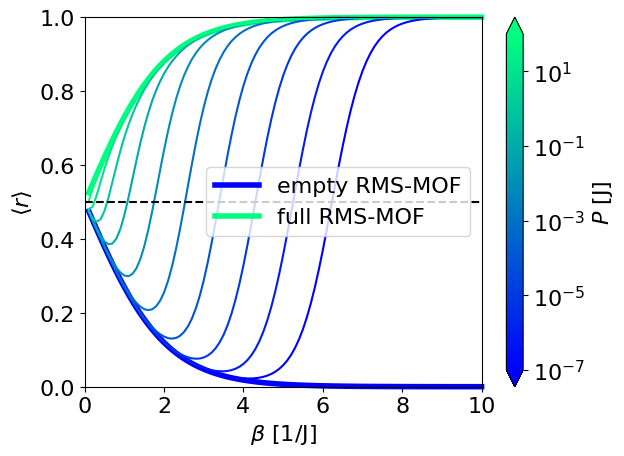

MORF material with:
	δ = 1.000
	ϵ♡ = -3.000
	ϵΔ = -1.000



In [49]:
material = Material(1.0, -3.0, -1.0)
println(material)
β = range(0.1, stop=10.0, length=100)

P = vcat([0.0], 10. .^ (-7:2))

r_empty = exp.(-β * material.δ) ./ (1.0 .+ exp.(-β * material.δ))
r_full = exp.(-β * (material.ϵ♡ + material.δ)) ./ (exp.(-β * material.ϵΔ) .+ exp.(-β * (material.ϵ♡ + material.δ)))

cnorm = PyPlot.matplotlib.colors.LogNorm(vmin=minimum(P[2:end]), vmax=maximum(P))
P_to_color = PyPlot.matplotlib.cm.ScalarMappable(norm=cnorm, cmap=PyPlot.matplotlib.cm.get_cmap("winter"))
P_to_color.set_array([])

fig, ax = subplots()
plot(β, r_empty, color=P_to_color.to_rgba(minimum(P)), label="empty RMS-MOF", lw=4, clip_on=false)
plot(β, r_full, color=P_to_color.to_rgba(maximum(P)), label="full RMS-MOF", lw=4, clip_on=false)
xlabel(L"$\beta$ [1/J]")
ylabel(L"$\langle r \rangle$")
for P_i in P
    r = [expected_r(material, β_i, β_i * P_i) for β_i in β]
    plot(β, r, color=P_to_color.to_rgba(P_i), clip_on=false)
end
axhline(y=0.5, color="k", linestyle="--")
colorbar(P_to_color, label=L"$P$ [J]", extend="both")
ylim([0, 1])
xlim([0, maximum(β)])
legend()
savefig("expected_r_T_dependence.pdf", format="pdf")